In [ ]:
import os
from pathlib import Path
import builtins
import json
import pandas as pd
import shutil

# 1. Mount Google Drive (if not already)
from google.colab import drive
if not os.path.exists('/content/drive'):
    print("Mounting Google Drive...")
    drive.mount('/content/drive')
    print("Google Drive mounted!")
else:
    print("Google Drive already mounted.")

# 2. Define base project directory on Drive (change if needed)
BASE_DIR = Path("/content/drive/MyDrive/intelligent_pesticide_system")

# 3. Change working directory to project root (optional)
os.chdir(str(BASE_DIR))
print(f"Working directory set to project root: {os.getcwd()}")

# 4. Patch built-in open() to redirect file paths under BASE_DIR automatically,
#    unless absolute path already points to BASE_DIR or special paths.

original_open = builtins.open

def patched_open(file, mode='r', buffering=-1, encoding=None,
                 errors=None, newline=None, closefd=True, opener=None):
    fpath = file
    if isinstance(file, str):
        if not (file.startswith(str(BASE_DIR)) or os.path.isabs(file)):
            # Redirect relative paths inside BASE_DIR
            fpath = BASE_DIR / file
    elif isinstance(file, Path):
        if not file.is_absolute():
            fpath = BASE_DIR / file
        else:
            fpath = file
    else:
        fpath = file  # If not str or Path, keep as is

    # Ensure parent directories exist for writing
    if 'w' in mode or 'a' in mode or 'x' in mode:
        os.makedirs(Path(fpath).parent, exist_ok=True)

    return original_open(fpath, mode, buffering, encoding, errors, newline, closefd, opener)

builtins.open = patched_open

# 5. Patch pandas read_csv and to_csv similarly

original_read_csv = pd.read_csv
def patched_read_csv(filepath_or_buffer, *args, **kwargs):
    if isinstance(filepath_or_buffer, str):
        if not filepath_or_buffer.startswith(str(BASE_DIR)):
            filepath_or_buffer = str(BASE_DIR / filepath_or_buffer)
    return original_read_csv(filepath_or_buffer, *args, **kwargs)
pd.read_csv = patched_read_csv

original_to_csv = pd.DataFrame.to_csv
def patched_to_csv(self, path_or_buf=None, *args, **kwargs):
    if isinstance(path_or_buf, str) and not path_or_buf.startswith(str(BASE_DIR)):
        path_or_buf = str(BASE_DIR / path_or_buf)
    os.makedirs(Path(path_or_buf).parent, exist_ok=True)
    return original_to_csv(self, path_or_buf, *args, **kwargs)
pd.DataFrame.to_csv = patched_to_csv

# 6. Patch torch.save similarly if using PyTorch

try:
    import torch

    original_torch_save = torch.save

    def patched_torch_save(obj, f, *args, **kwargs):
        if isinstance(f, str):
            if not f.startswith(str(BASE_DIR)):
                f = str(BASE_DIR / f)
            os.makedirs(Path(f).parent, exist_ok=True)
        return original_torch_save(obj, f, *args, **kwargs)

    torch.save = patched_torch_save
except ImportError:
    print("PyTorch not installed, skipping torch.save patch")

# 7. Patch matplotlib.pyplot.savefig to save inside the project folder automatically

import matplotlib.pyplot as plt
original_savefig = plt.savefig

def patched_savefig(fname, *args, **kwargs):
    if isinstance(fname, str):
        if not fname.startswith(str(BASE_DIR)):
            fname = str(BASE_DIR / fname)
        os.makedirs(Path(fname).parent, exist_ok=True)
    return original_savefig(fname, *args, **kwargs)

plt.savefig = patched_savefig

print("Universal drive path redirection is active. All file reads/writes go to your Drive folder!")


Google Drive already mounted.
Working directory set to project root: /content/drive/MyDrive/intelligent_pesticide_system
Universal drive path redirection is active. All file reads/writes go to your Drive folder!


In [ ]:
import os
import json
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import torch
from tqdm import tqdm
import warnings

# Data augmentation libraries
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Load project configuration
current_dir = Path.cwd()
if current_dir.name == 'notebooks':
    BASE_DIR = current_dir.parent
else:
    BASE_DIR = current_dir

CONFIGS_DIR = BASE_DIR / "configs"
METADATA_DIR = BASE_DIR / "data" / "metadata"

# Load configuration
config_file = CONFIGS_DIR / "runtime_config.json"
if config_file.exists():
    with open(config_file, 'r') as f:
        config = json.load(f)
    print("✅ Configuration loaded")
else:
    print("⚠️  Config file not found, using defaults")
    config = {'model_params': {'image_size': 512}}

# Load dataset summary
dataset_summary_file = METADATA_DIR / "dataset_summary.json"
if dataset_summary_file.exists():
    with open(dataset_summary_file, 'r') as f:
        dataset_info = json.load(f)
    print("✅ Dataset summary loaded")
else:
    print("⚠️  Dataset summary not found, run notebook 2 first")
    dataset_info = {}

print("🎨 DATA AUGMENTATION PIPELINE")
print("=" * 60)
print(f"Base Directory: {BASE_DIR}")
print(f"Image Size: {config.get('model_params', {}).get('image_size', 512)}")
print(f"Device: {config.get('device', 'cpu')}")


✅ Configuration loaded
✅ Dataset summary loaded
🎨 DATA AUGMENTATION PIPELINE
Base Directory: C:\Users\barat\intelligent_pesticide_system
Image Size: 512
Device: cuda


In [ ]:
class AugmentationPipeline:
    """Comprehensive augmentation pipeline for plant disease datasets"""

    def __init__(self, image_size=512, severity='medium'):
        self.image_size = image_size
        self.severity = severity

        # Define augmentation intensities
        self.intensity_params = {
            'light': {
                'rotation_limit': 25,
                'brightness_limit': 0.2,
                'contrast_limit': 0.2,
                'noise_limit': 35,
                'blur_limit': 5
            },
            'medium': {
                'rotation_limit': 45,
                'brightness_limit': 0.4,
                'contrast_limit': 0.4,
                'noise_limit': 60,
                'blur_limit': 7
            },
            'strong': {
                'rotation_limit': 60,
                'brightness_limit': 0.5,
                'contrast_limit': 0.5,
                'noise_limit': 80,
                'blur_limit': 9
            }
        }

        self.params = self.intensity_params[severity]

    def get_segmentation_augmentations(self, mode='train'):
        """Enhanced segmentation augmentations"""

        if mode == 'train':
            return A.Compose([
                # Geometric transformations
                A.Resize(self.image_size, self.image_size),
                A.Rotate(limit=self.params['rotation_limit'], p=0.9),  # Increased probability
                A.HorizontalFlip(p=0.6),  # Increased
                A.VerticalFlip(p=0.4),    # Increased
                A.RandomScale(scale_limit=0.2, p=0.7),  # More aggressive scaling

                # Advanced spatial transformations
                A.ElasticTransform(alpha=2, sigma=25, p=0.5),  # More aggressive
                A.GridDistortion(num_steps=6, distort_limit=0.2, p=0.5),  # Stronger distortion
                A.OpticalDistortion(distort_limit=0.2, shift_limit=0.08, p=0.5),

                # Aggressive color transformations
                A.RandomBrightnessContrast(
                    brightness_limit=self.params['brightness_limit'],
                    contrast_limit=self.params['contrast_limit'],
                    p=0.9),  # Higher probability
                A.HueSaturationValue(
                    hue_shift_limit=20,    # More aggressive
                    sat_shift_limit=25,
                    val_shift_limit=20,
                    p=0.8),  # Higher probability
                A.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.15, p=0.7),
                A.RGBShift(r_shift_limit=20, g_shift_limit=20, b_shift_limit=20, p=0.6),

                # Enhanced noise augmentations
                A.OneOf([
                    A.GaussNoise(var_limit=(15, self.params['noise_limit']), p=0.7),
                    A.ISONoise(color_shift=(0.02, 0.08), intensity=(0.2, 0.7), p=0.6),
                    A.MultiplicativeNoise(multiplier=[0.7, 1.3], p=0.5)
                ], p=0.6),  # Higher probability

                # Enhanced blur variants
                A.OneOf([
                    A.MotionBlur(blur_limit=self.params['blur_limit'], p=0.5),
                    A.MedianBlur(blur_limit=7, p=0.4),
                    A.GaussianBlur(blur_limit=self.params['blur_limit'], p=0.5),
                    A.Blur(blur_limit=7, p=0.4),
                ], p=0.5),

                # Weather and environmental effects
                A.OneOf([
                    A.RandomFog(fog_coef_lower=0.2, fog_coef_upper=0.5, p=0.4),
                    A.RandomSunFlare(flare_roi=(0, 0, 1, 0.5), angle_lower=0, angle_upper=1, p=0.3),
                    A.RandomShadow(shadow_roi=(0, 0.3, 1, 1), num_shadows_lower=1, num_shadows_upper=3, p=0.4),
                ], p=0.4),  # Higher probability

                # Additional quality degradations
                A.Downscale(scale_min=0.7, scale_max=0.9, p=0.3),  # Simulate low-res cameras
                A.ImageCompression(quality_lower=60, quality_upper=90, p=0.3),  # JPEG artifacts

                # Final normalization
                A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ToTensorV2()
            ])
        else:
            return A.Compose([
                A.Resize(self.image_size, self.image_size),
                A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ToTensorV2()
            ])



    def get_classification_augmentations(self, mode='train'):
        """Enhanced classification augmentations"""

        if mode == 'train':
            return A.Compose([
                # Geometric transformations
                A.Resize(self.image_size, self.image_size),
                A.Rotate(limit=self.params['rotation_limit'], p=0.95),  # Very high probability
                A.HorizontalFlip(p=0.7),
                A.VerticalFlip(p=0.5),
                A.RandomScale(scale_limit=0.25, p=0.8),  # More aggressive
                A.Transpose(p=0.4),

                # Crops and spatial
                A.RandomResizedCrop(
                    height=self.image_size, width=self.image_size,
                    scale=(0.6, 1.0), ratio=(0.6, 1.4), p=0.8),  # More aggressive cropping

                # Advanced spatial distortions
                A.ElasticTransform(alpha=3, sigma=30, p=0.6),  # More aggressive
                A.GridDistortion(num_steps=7, distort_limit=0.25, p=0.6),
                A.OpticalDistortion(distort_limit=0.25, shift_limit=0.1, p=0.6),

                # Aggressive color augmentations
                A.RandomBrightnessContrast(
                    brightness_limit=self.params['brightness_limit'],
                    contrast_limit=self.params['contrast_limit'], p=0.95),
                A.HueSaturationValue(
                    hue_shift_limit=25, sat_shift_limit=30, val_shift_limit=25, p=0.85),
                A.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2, p=0.8),
                A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.7),

                # Channel operations
                A.ChannelShuffle(p=0.4),
                A.ToGray(p=0.2),  # Higher probability

                # Enhanced noise
                A.OneOf([
                    A.GaussNoise(var_limit=(20, self.params['noise_limit']), p=0.8),
                    A.ISONoise(color_shift=(0.03, 0.1), intensity=(0.2, 0.8), p=0.7),
                    A.MultiplicativeNoise(multiplier=[0.6, 1.4], p=0.6)
                ], p=0.7),  # Much higher probability

                # Enhanced blur
                A.OneOf([
                    A.MotionBlur(blur_limit=self.params['blur_limit'], p=0.6),
                    A.MedianBlur(blur_limit=9, p=0.5),
                    A.GaussianBlur(blur_limit=self.params['blur_limit'], p=0.6),
                    A.Blur(blur_limit=9, p=0.5),
                ], p=0.6),

                # Weather and environmental
                A.OneOf([
                    A.RandomFog(fog_coef_lower=0.2, fog_coef_upper=0.6, p=0.5),
                    A.RandomSunFlare(flare_roi=(0, 0, 1, 0.5), p=0.4),
                    A.RandomShadow(shadow_roi=(0, 0.2, 1, 1), num_shadows_lower=1, num_shadows_upper=4, p=0.5),
                ], p=0.5),

                # Quality degradations (simulate real camera conditions)
                A.Downscale(scale_min=0.6, scale_max=0.9, p=0.4),
                A.ImageCompression(quality_lower=50, quality_upper=85, p=0.4),
                A.Posterize(num_bits=6, p=0.2),  # Reduce color depth

                # Cutout/Dropout augmentation
                A.CoarseDropout(max_holes=8, max_height=0.1, max_width=0.1, p=0.4),

                A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ToTensorV2()
            ])
        else:
            return A.Compose([
                A.Resize(self.image_size, self.image_size),
                A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ToTensorV2()
            ])



print("🎨 Augmentation pipeline classes defined")
print("✅ Supports both segmentation and classification tasks")
print("✅ Three intensity levels: light, medium, strong")


🎨 Augmentation pipeline classes defined
✅ Supports both segmentation and classification tasks
✅ Three intensity levels: light, medium, strong


🧪 TESTING AUGMENTATION PIPELINES
✅ Created light augmentation pipeline
✅ Created medium augmentation pipeline
✅ Created strong augmentation pipeline
🔬 Testing segmentation augmentations with PlantSeg data:

🔍 Testing segmentation augmentations
Original image shape: (480, 640, 3)
Original mask shape: (480, 640)


C:\Users\barat\anaconda3\envs\torch_gpu\Lib\site-packages\albumentations\augmentations\blur\transforms.py:184: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  warnings.warn(
C:\Users\barat\anaconda3\envs\torch_gpu\Lib\site-packages\albumentations\augmentations\transforms.py:1692: UserWarning: Using default interpolation INTER_NEAREST, which is sub-optimal.Please specify interpolation mode for downscale and upscale explicitly.For additional information see this PR https://github.com/albumentations-team/albumentations/pull/584
  warnings.warn(


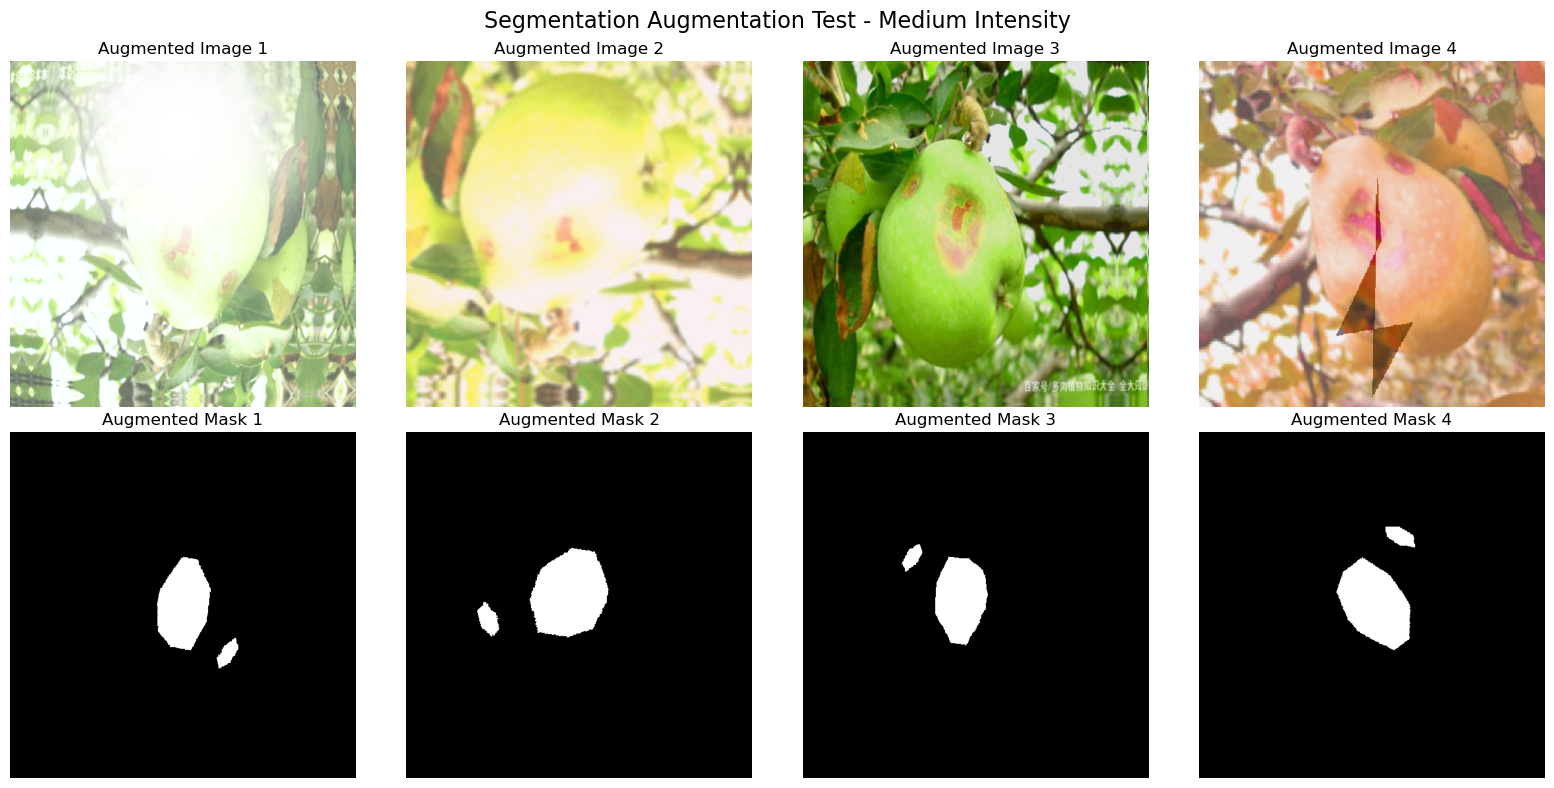

🔬 Testing classification augmentations with DiaMOS data:

🔍 Testing classification augmentations
Original image shape: (3968, 2976, 3)


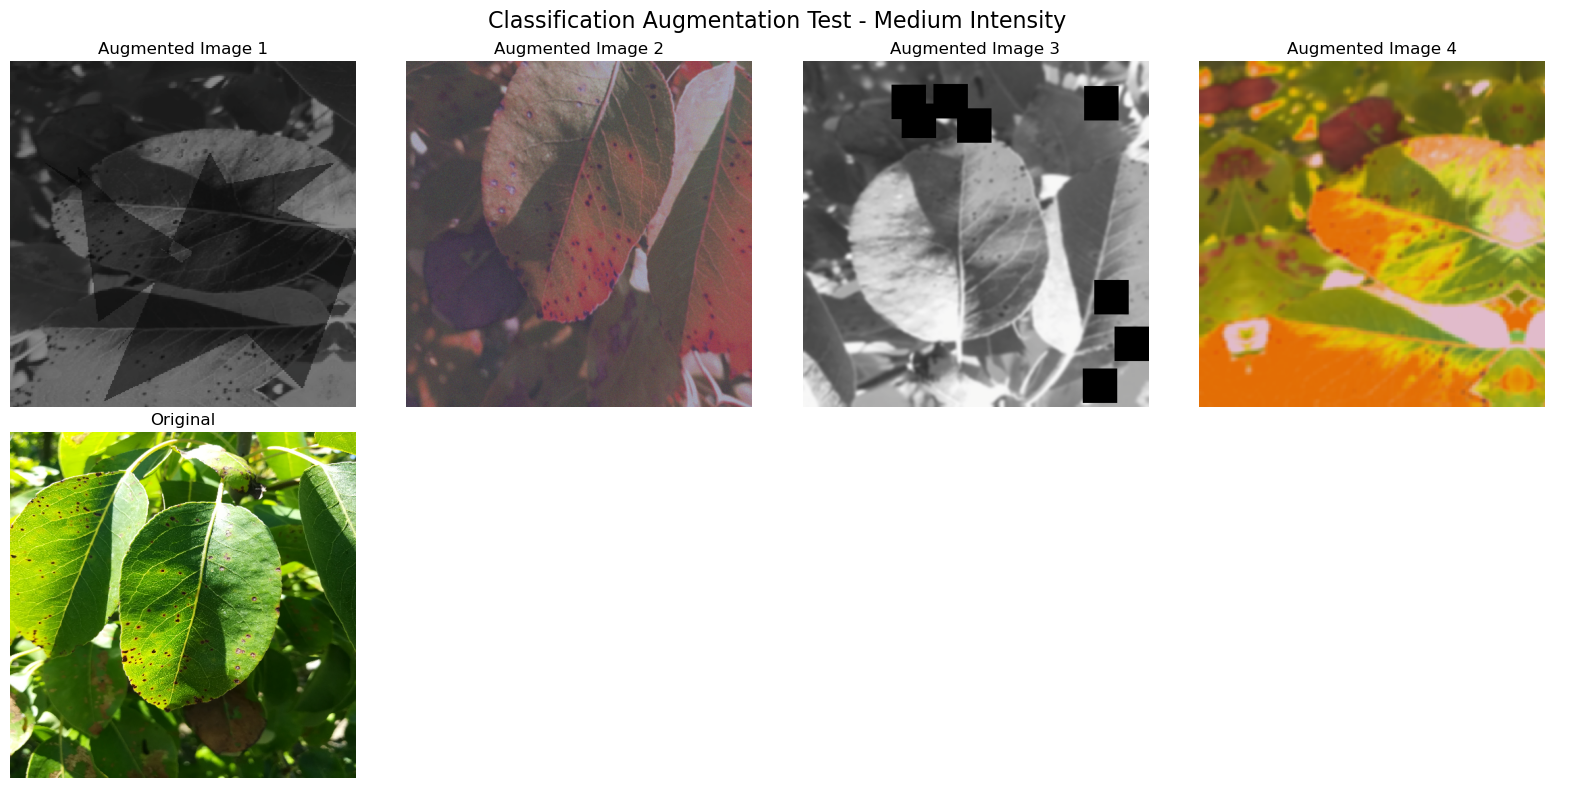

In [ ]:
# Initialize augmentation pipelines
IMAGE_SIZE = config.get('model_params', {}).get('image_size', 512)

print("🧪 TESTING AUGMENTATION PIPELINES")
print("=" * 60)

# Create pipelines for different intensities
pipelines = {}
for intensity in ['light', 'medium', 'strong']:
    pipelines[intensity] = AugmentationPipeline(
        image_size=IMAGE_SIZE,
        severity=intensity
    )
    print(f"✅ Created {intensity} augmentation pipeline")

# Test with sample data
def test_augmentation_pipeline(image_path, mask_path=None, num_samples=4):
    """Test augmentation pipeline with sample data"""

    # Load sample image
    if not Path(image_path).exists():
        print(f"❌ Sample image not found: {image_path}")
        return

    image = cv2.imread(str(image_path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Load mask if provided (for segmentation)
    mask = None
    if mask_path and Path(mask_path).exists():
        mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
        task_type = 'segmentation'
    else:
        task_type = 'classification'

    print(f"\n🔍 Testing {task_type} augmentations")
    print(f"Original image shape: {image.shape}")
    if mask is not None:
        print(f"Original mask shape: {mask.shape}")

    # Test medium intensity pipeline
    aug_pipeline = pipelines['medium']

    if task_type == 'segmentation':
        transform = aug_pipeline.get_segmentation_augmentations(mode='train')
    else:
        transform = aug_pipeline.get_classification_augmentations(mode='train')

    # Create augmented samples
    fig, axes = plt.subplots(2, num_samples, figsize=(16, 8))

    for i in range(num_samples):
        try:
            if mask is not None:
                # Segmentation task
                augmented = transform(image=image, mask=mask)
                aug_image = augmented['image']
                aug_mask = augmented['mask']

                # Convert tensor back to numpy for display
                if torch.is_tensor(aug_image):
                    # Denormalize for display
                    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
                    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
                    aug_image = aug_image * std + mean
                    aug_image = aug_image.clamp(0, 1)
                    aug_image = aug_image.permute(1, 2, 0).numpy()

                axes[0, i].imshow(aug_image)
                axes[0, i].set_title(f'Augmented Image {i+1}')
                axes[0, i].axis('off')

                if torch.is_tensor(aug_mask):
                    aug_mask = aug_mask.numpy()

                axes[1, i].imshow(aug_mask, cmap='gray')
                axes[1, i].set_title(f'Augmented Mask {i+1}')
                axes[1, i].axis('off')

            else:
                # Classification task
                augmented = transform(image=image)
                aug_image = augmented['image']

                # Convert tensor back to numpy for display
                if torch.is_tensor(aug_image):
                    # Denormalize for display
                    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
                    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
                    aug_image = aug_image * std + mean
                    aug_image = aug_image.clamp(0, 1)
                    aug_image = aug_image.permute(1, 2, 0).numpy()

                axes[0, i].imshow(aug_image)
                axes[0, i].set_title(f'Augmented Image {i+1}')
                axes[0, i].axis('off')

                # Show original in bottom row
                if i == 0:
                    resized_original = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
                    axes[1, i].imshow(resized_original)
                    axes[1, i].set_title('Original')
                    axes[1, i].axis('off')
                else:
                    axes[1, i].axis('off')

        except Exception as e:
            print(f"Error in augmentation {i+1}: {e}")
            axes[0, i].text(0.5, 0.5, f'Error: {str(e)[:20]}...',
                          ha='center', va='center', transform=axes[0, i].transAxes)
            axes[0, i].set_title(f'Error {i+1}')

    plt.suptitle(f'{task_type.capitalize()} Augmentation Test - Medium Intensity', fontsize=16)
    plt.tight_layout()
    plt.show()

# Try to find sample images for testing
sample_files = {
    'plantseg_image': None,
    'plantseg_mask': None,
    'diamos_image': None
}

# Look for PlantSeg samples
plantseg_train_csv = METADATA_DIR / "plantseg_train.csv"
if plantseg_train_csv.exists():
    plantseg_df = pd.read_csv(plantseg_train_csv)
    if len(plantseg_df) > 0:
        sample_row = plantseg_df.iloc[0]
        sample_files['plantseg_image'] = sample_row['image_path']
        sample_files['plantseg_mask'] = sample_row['mask_path']

# Look for DiaMOS samples
diamos_train_csv = METADATA_DIR / "diamos_train.csv"
if diamos_train_csv.exists():
    diamos_df = pd.read_csv(diamos_train_csv)
    if len(diamos_df) > 0:
        sample_row = diamos_df.iloc[0]
        sample_files['diamos_image'] = sample_row['image_path']

# Test segmentation augmentations
if sample_files['plantseg_image']:
    print("🔬 Testing segmentation augmentations with PlantSeg data:")
    test_augmentation_pipeline(
        sample_files['plantseg_image'],
        sample_files['plantseg_mask']
    )

# Test classification augmentations
if sample_files['diamos_image']:
    print("🔬 Testing classification augmentations with DiaMOS data:")
    test_augmentation_pipeline(sample_files['diamos_image'])

if not any(sample_files.values()):
    print("⚠️  No sample files found. Run notebook 2 first to prepare datasets.")


warnings.filterwarnings('ignore')

📊 AUGMENTATION STATISTICS & ANALYSIS
🔍 Analyzing segmentation augmentation effects (200 samples)


Generating samples: 100%|████████████████████████████████████████████████████████████| 200/200 [00:23<00:00,  8.57it/s]


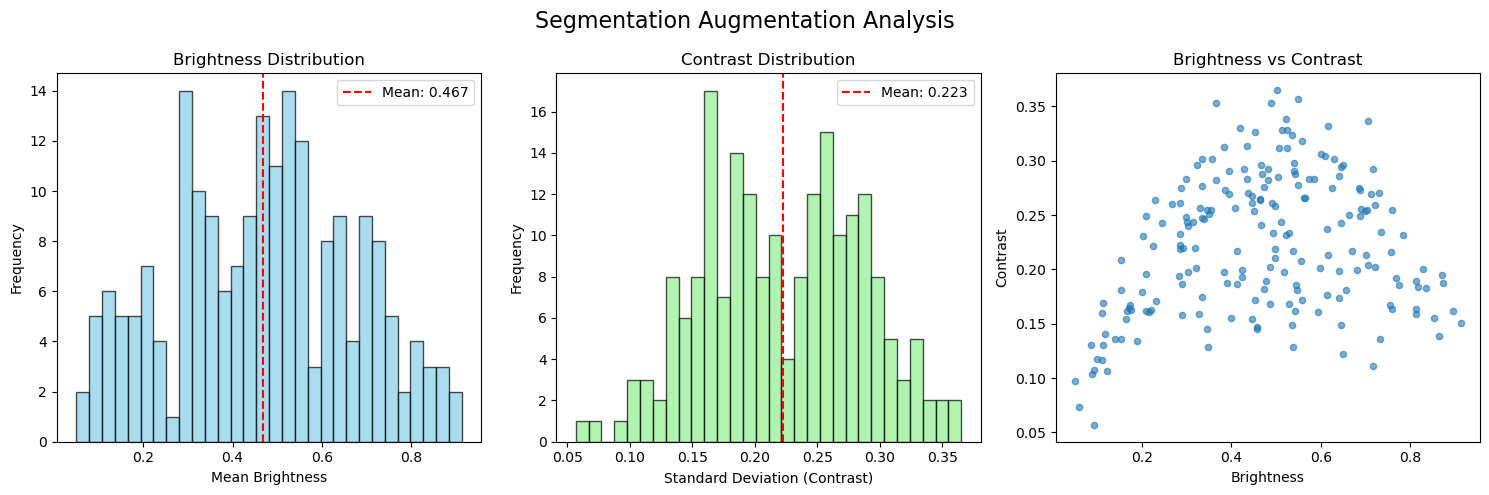


📈 AUGMENTATION STATISTICS:
Brightness - Mean: 0.467, Std: 0.205
Contrast - Mean: 0.223, Std: 0.063
Range - Brightness: [0.051, 0.913]
Range - Contrast: [0.057, 0.365]
🔍 Analyzing classification augmentation effects (200 samples)


Generating samples: 100%|████████████████████████████████████████████████████████████| 200/200 [00:19<00:00, 10.39it/s]


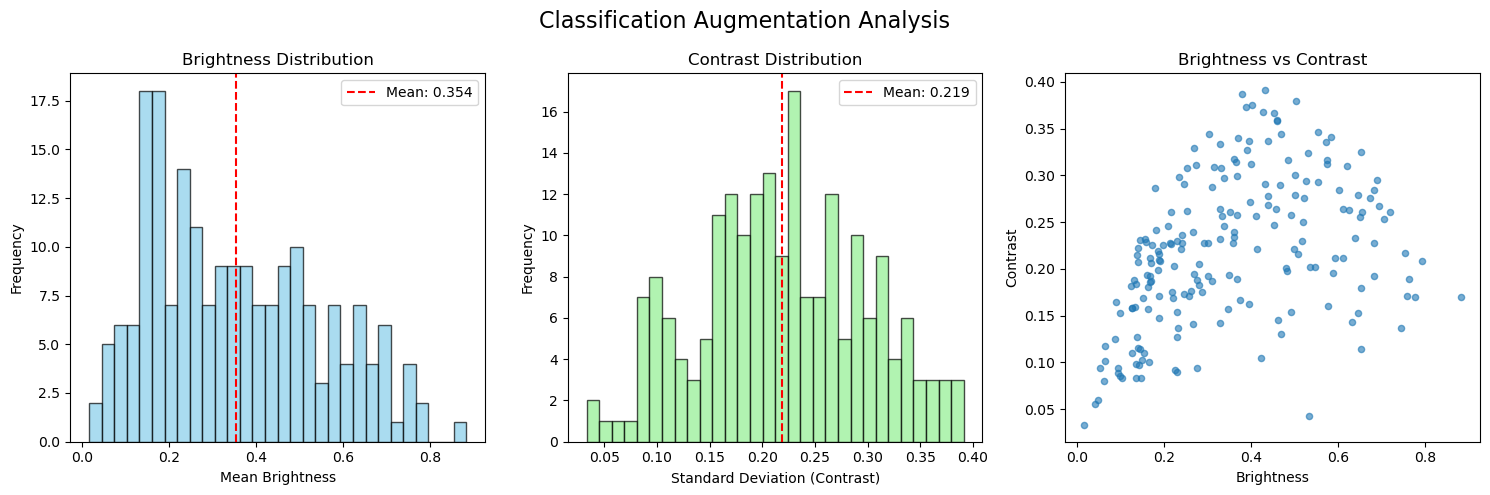


📈 AUGMENTATION STATISTICS:
Brightness - Mean: 0.354, Std: 0.195
Contrast - Mean: 0.219, Std: 0.079
Range - Brightness: [0.017, 0.883]
Range - Contrast: [0.033, 0.391]


In [ ]:
# Analyze augmentation effects
print("📊 AUGMENTATION STATISTICS & ANALYSIS")
print("=" * 60)

def analyze_augmentation_effects(image_path, mask_path=None, num_samples=100):
    """Analyze statistical effects of augmentations"""

    if not Path(image_path).exists():
        print(f"❌ Sample image not found: {image_path}")
        return

    # Load sample image and mask
    image = cv2.imread(str(image_path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = None
    if mask_path and Path(mask_path).exists():
        mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
        task_type = 'segmentation'
        transform = pipelines['medium'].get_segmentation_augmentations(mode='train')
    else:
        task_type = 'classification'
        transform = pipelines['medium'].get_classification_augmentations(mode='train')

    print(f"🔍 Analyzing {task_type} augmentation effects ({num_samples} samples)")

    # Generate augmented samples
    brightness_values = []
    contrast_values = []

    for i in tqdm(range(num_samples), desc="Generating samples"):
        try:
            if mask is not None:
                augmented = transform(image=image, mask=mask)
            else:
                augmented = transform(image=image)

            aug_image = augmented['image']

            # Convert to numpy if tensor
            if torch.is_tensor(aug_image):
                # Denormalize
                mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
                std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
                aug_image = aug_image * std + mean
                aug_image = aug_image.clamp(0, 1).numpy()

            # Calculate statistics
            brightness = np.mean(aug_image)
            contrast = np.std(aug_image)

            brightness_values.append(brightness)
            contrast_values.append(contrast)

        except Exception as e:
            print(f"Error in sample {i}: {e}")
            continue

    # Create analysis plots
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Brightness distribution
    axes[0].hist(brightness_values, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0].set_title('Brightness Distribution')
    axes[0].set_xlabel('Mean Brightness')
    axes[0].set_ylabel('Frequency')
    axes[0].axvline(np.mean(brightness_values), color='red', linestyle='--',
                    label=f'Mean: {np.mean(brightness_values):.3f}')
    axes[0].legend()

    # Contrast distribution
    axes[1].hist(contrast_values, bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
    axes[1].set_title('Contrast Distribution')
    axes[1].set_xlabel('Standard Deviation (Contrast)')
    axes[1].set_ylabel('Frequency')
    axes[1].axvline(np.mean(contrast_values), color='red', linestyle='--',
                    label=f'Mean: {np.mean(contrast_values):.3f}')
    axes[1].legend()

    # Brightness vs Contrast scatter
    axes[2].scatter(brightness_values, contrast_values, alpha=0.6, s=20)
    axes[2].set_xlabel('Brightness')
    axes[2].set_ylabel('Contrast')
    axes[2].set_title('Brightness vs Contrast')

    plt.suptitle(f'{task_type.capitalize()} Augmentation Analysis', fontsize=16)
    plt.tight_layout()
    plt.show()

    # Print statistics
    print(f"\n📈 AUGMENTATION STATISTICS:")
    print(f"Brightness - Mean: {np.mean(brightness_values):.3f}, Std: {np.std(brightness_values):.3f}")
    print(f"Contrast - Mean: {np.mean(contrast_values):.3f}, Std: {np.std(contrast_values):.3f}")
    print(f"Range - Brightness: [{np.min(brightness_values):.3f}, {np.max(brightness_values):.3f}]")
    print(f"Range - Contrast: [{np.min(contrast_values):.3f}, {np.max(contrast_values):.3f}]")

# Run analysis if sample data available
if sample_files['plantseg_image']:
    analyze_augmentation_effects(
        sample_files['plantseg_image'],
        sample_files['plantseg_mask'],
        num_samples=200
    )

if sample_files['diamos_image']:
    analyze_augmentation_effects(sample_files['diamos_image'], num_samples=200)


warnings.filterwarnings('ignore')

In [ ]:
# Save augmentation configuration for training
print("💾 SAVING AUGMENTATION CONFIGURATION")
print("=" * 60)

# Create augmentation config
augmentation_config = {
    'image_size': IMAGE_SIZE,
    'normalization': {
        'mean': [0.485, 0.456, 0.406],
        'std': [0.229, 0.224, 0.225]
    },
    'intensities': pipelines['medium'].intensity_params,
    'segmentation_augmentations': {
        'geometric': ['rotate', 'flip_horizontal', 'flip_vertical', 'random_scale'],
        'spatial': ['elastic_transform', 'grid_distortion', 'optical_distortion'],
        'color': ['brightness_contrast', 'hue_saturation', 'color_jitter'],
        'noise': ['gauss_noise', 'iso_noise'],
        'blur': ['motion_blur', 'median_blur', 'gaussian_blur'],
        'weather': ['random_fog', 'sun_flare']
    },
    'classification_augmentations': {
        'geometric': ['rotate', 'flip_horizontal', 'flip_vertical', 'transpose', 'random_scale'],
        'spatial': ['elastic_transform', 'grid_distortion', 'optical_distortion', 'random_crop'],
        'color': ['brightness_contrast', 'hue_saturation', 'color_jitter', 'rgb_shift', 'channel_shuffle'],
        'noise': ['gauss_noise', 'iso_noise', 'multiplicative_noise'],
        'blur': ['motion_blur', 'median_blur', 'gaussian_blur'],
        'weather': ['random_fog', 'sun_flare', 'random_shadow'],
        'quality': ['to_gray']
    },
    'probabilities': {
        'geometric_transforms': 0.8,
        'color_transforms': 0.7,
        'noise_blur': 0.4,
        'weather_effects': 0.3,
        'spatial_transforms': 0.4
    },
    'ready_for_training': True
}

# Save configuration
augmentation_config_file = CONFIGS_DIR / 'augmentation_config.json'
with open(augmentation_config_file, 'w') as f:
    json.dump(augmentation_config, f, indent=2)

print(f"✅ Augmentation configuration saved to: {augmentation_config_file}")

# Create summary
print(f"\n📋 AUGMENTATION SUMMARY:")
print(f"✅ Image size: {IMAGE_SIZE}x{IMAGE_SIZE}")
print(f"✅ Segmentation augmentations: {len(augmentation_config['segmentation_augmentations'])} categories")
print(f"✅ Classification augmentations: {len(augmentation_config['classification_augmentations'])} categories")
print(f"✅ Three intensity levels available")
print(f"✅ Normalization: ImageNet standards")


print(f"\n🎉 Data augmentation setup complete!")


💾 SAVING AUGMENTATION CONFIGURATION
✅ Augmentation configuration saved to: C:\Users\barat\intelligent_pesticide_system\configs\augmentation_config.json

📋 AUGMENTATION SUMMARY:
✅ Image size: 512x512
✅ Segmentation augmentations: 6 categories
✅ Classification augmentations: 7 categories
✅ Three intensity levels available
✅ Normalization: ImageNet standards

🎉 Data augmentation setup complete!
